In [1]:
import pandas as pd
import seaborn as sbn
import geopandas as geo_pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import sqlite3
import os

In [2]:
data_dir_prefix = '../../../../data/'

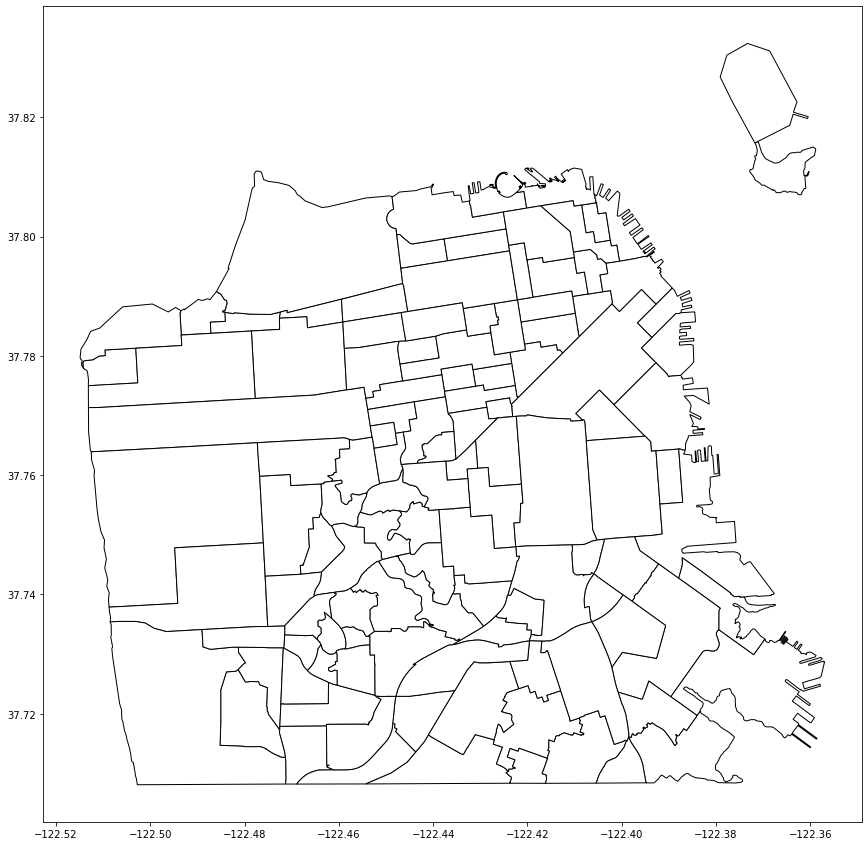

In [3]:
plt.rcParams["figure.figsize"]=15,15

sf_neighborhoods = geo_pd.read_file(data_dir_prefix+'raw/SF Find Neighborhoods.geojson')
base_map = sf_neighborhoods.geometry.plot(edgecolor="black", color="white")


In [5]:
zone_distances = pd.read_csv(data_dir_prefix + "/raw/zone_distances.csv")
zone_distances.head()


,Unnamed: 0,zone_from_lat,zone_from_lon,zone_to_lat,zone_to_lon,travel_distance_km,travel_time_notraffic_seconds,travel_time_traffic_seconds
0,0,37.810886,-122.477584,37.735941,-122.408273,14.162,1325,1508
1,1,37.735941,-122.408273,37.810886,-122.477584,14.162,1325,1508
2,2,37.711104,-122.408091,37.712454,-122.380709,3.283,509,535
3,3,37.712454,-122.380709,37.711104,-122.408091,3.283,509,535
4,4,37.748523,-122.486857,37.736026,-122.424099,11.139,1007,1002


In [179]:
zone_from = geo_pd.points_from_xy(zone_distances.zone_from_lon, zone_distances.zone_from_lat, crs="EPSG:4326")
zone_to = geo_pd.points_from_xy(zone_distances.zone_to_lon, zone_distances.zone_to_lat, crs="EPSG:4326")

zone_geo = geo_pd.GeoDataFrame({
    "zone_from": geo_pd.GeoSeries(zone_from),
    "zone_to": geo_pd.GeoSeries(zone_to),
    "travel_time_notraffic_seconds": pd.Series(zone_distances.travel_time_notraffic_seconds),
    "travel_time_traffic_seconds": pd.Series(zone_distances.travel_time_traffic_seconds),
    "travel_distance_km": pd.Series(zone_distances.travel_distance_km)
    }, geometry="zone_from")


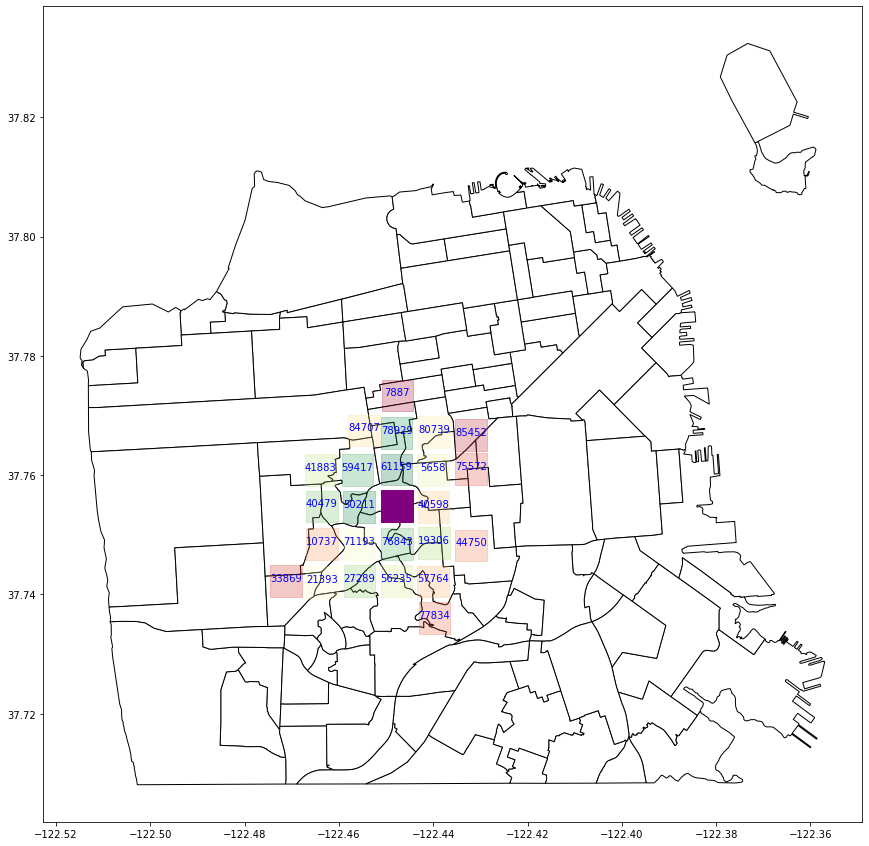

In [180]:
zone_travel_test = zone_geo.loc[zone_geo.zone_from.eq(zone_geo.zone_from[142])]
zone_travel_test = zone_travel_test.reset_index()
zone_travel_test = zone_travel_test.loc[zone_travel_test.travel_time_notraffic_seconds <= 60 * 6 * 1.5]
zone_travel_test = zone_travel_test.sort_values("travel_time_notraffic_seconds", axis=0)

base_map = sf_neighborhoods.geometry.plot(edgecolor="black", color="white")

_ = zone_travel_test.zone_from.plot(c="purple", marker="s", markersize=1000, ax=base_map)
_ = zone_travel_test.zone_to.plot(markersize=1000, marker="s", c = zone_travel_test.travel_time_notraffic_seconds.to_numpy(), ax=base_map, alpha=0.25, cmap=plt.cm.RdYlGn.reversed())

_ = zone_travel_test.apply(
    lambda x: base_map.annotate(
        text=str(x["index"]), 
        xy=x.zone_to.coords[0], 
        color='blue', 
        ha='center', 
        size="10"), axis=1)


In [132]:
import shapely.wkt

zone_grid = pd.read_csv(data_dir_prefix+"/raw/zone_grid.csv")
zone_grid = zone_grid.loc[:, ['zone_idx', 'zone', 'centroid']]
zone_grid['zone'] = zone_grid['zone'].apply(shapely.wkt.loads)
zone_grid['centroid'] = zone_grid['centroid'].apply(shapely.wkt.loads)
zone_grid = geo_pd.GeoDataFrame(zone_grid, geometry="zone", crs="EPSG:4326")
zone_grid

,zone_idx,zone,centroid
0,7,"POLYGON ((-122.51490 37.78889, -122.51490 37.7...",POINT (-122.5109493508999 37.78578093837502)
1,8,"POLYGON ((-122.51490 37.78267, -122.51490 37.7...",POINT (-122.5109493508999 37.77956560002502)
2,27,"POLYGON ((-122.50700 37.78889, -122.50700 37.7...",POINT (-122.5030535886999 37.78578093837502)
3,28,"POLYGON ((-122.50700 37.78267, -122.50700 37.7...",POINT (-122.5030535886999 37.77956560002502)
4,47,"POLYGON ((-122.49911 37.78889, -122.49911 37.7...",POINT (-122.4951578264999 37.78578093837502)
...,...,...,...
294,343,"POLYGON ((-122.38067 37.81375, -122.38067 37.8...",POINT (-122.3767213935 37.81064229177503)
295,363,"POLYGON ((-122.37277 37.81375, -122.37277 37.8...",POINT (-122.3688256313 37.81064229177503)
296,364,"POLYGON ((-122.37277 37.80753, -122.37277 37.8...",POINT (-122.3688256313 37.80442695342503)
297,383,"POLYGON ((-122.36488 37.81375, -122.36488 37.8...",POINT (-122.3609298691 37.81064229177503)


<AxesSubplot:>

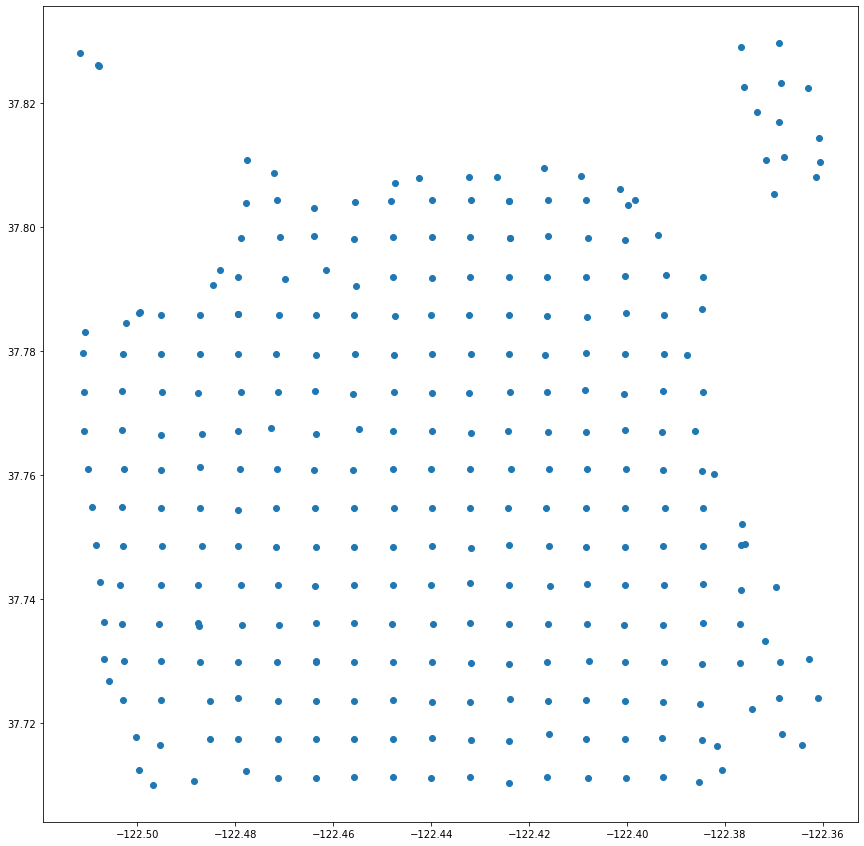

In [142]:
travel_pts = zone_check.loc[:, ['zone_from']].drop_duplicates()
travel_pts.plot()

In [148]:
zone_mappings = geo_pd.sjoin(travel_pts, zone_grid, how="inner", op="within")

In [149]:
zone_mappings

,zone_from,index_right,zone_idx,centroid
0,POINT (-122.47758 37.81089),73,83,POINT (-122.4793663020999 37.81064229177503)
1,POINT (-122.40827 37.73594),220,275,POINT (-122.4083044423 37.73605823157499)
2,POINT (-122.40809 37.71110),231,279,POINT (-122.4083044423 37.71119687817497)
3,POINT (-122.38071 37.71245),274,339,POINT (-122.3846171557 37.71119687817497)
197,POINT (-122.38541 37.71055),274,339,POINT (-122.3846171557 37.71119687817497)
...,...,...,...,...
1321,POINT (-122.43197 37.77955),164,208,POINT (-122.4319917289 37.77956560002502)
1360,POINT (-122.45575 37.71122),116,159,POINT (-122.4556790155 37.71119687817497)
1723,POINT (-122.46394 37.76089),101,131,POINT (-122.4635747777 37.76091958497501)
1778,POINT (-122.48671 37.76658),14,70,POINT (-122.4872620642999 37.76713492332501)


In [152]:
zone_mappings = zone_mappings.loc[zone_mappings.groupby('zone_idx').cumcount() < 1]

In [154]:
zone_mappings = zone_mappings.loc[:, ['zone_from', 'zone_idx']].reset_index
zone_mappings

,zone_from,zone_idx
0,POINT (-122.47758 37.81089),83
1,POINT (-122.40827 37.73594),275
2,POINT (-122.40809 37.71110),279
3,POINT (-122.38071 37.71245),339
4,POINT (-122.48686 37.74852),73
...,...,...
1321,POINT (-122.43197 37.77955),208
1360,POINT (-122.45575 37.71122),159
1723,POINT (-122.46394 37.76089),131
1778,POINT (-122.48671 37.76658),70


In [173]:
zone_from_mapping = zone_mappings.rename(columns={"zone_idx":"zone_from_idx"})
zone_to_mapping = zone_mappings.rename(columns={"zone_idx":"zone_to_idx", "zone_from":"zone_to"})

In [174]:
zone_grid

,zone_idx,zone,centroid
0,7,"POLYGON ((-122.51490 37.78889, -122.51490 37.7...",POINT (-122.5109493508999 37.78578093837502)
1,8,"POLYGON ((-122.51490 37.78267, -122.51490 37.7...",POINT (-122.5109493508999 37.77956560002502)
2,27,"POLYGON ((-122.50700 37.78889, -122.50700 37.7...",POINT (-122.5030535886999 37.78578093837502)
3,28,"POLYGON ((-122.50700 37.78267, -122.50700 37.7...",POINT (-122.5030535886999 37.77956560002502)
4,47,"POLYGON ((-122.49911 37.78889, -122.49911 37.7...",POINT (-122.4951578264999 37.78578093837502)
...,...,...,...
294,343,"POLYGON ((-122.38067 37.81375, -122.38067 37.8...",POINT (-122.3767213935 37.81064229177503)
295,363,"POLYGON ((-122.37277 37.81375, -122.37277 37.8...",POINT (-122.3688256313 37.81064229177503)
296,364,"POLYGON ((-122.37277 37.80753, -122.37277 37.8...",POINT (-122.3688256313 37.80442695342503)
297,383,"POLYGON ((-122.36488 37.81375, -122.36488 37.8...",POINT (-122.3609298691 37.81064229177503)


In [194]:
zone_geo_idx = zone_geo.merge(zone_from_mapping, on="zone_from", how="inner").merge(zone_to_mapping, on="zone_to", how="inner")
zone_geo_idx.dtypes

zone_from                        geometry
zone_to                          geometry
travel_time_notraffic_seconds       int64
travel_time_traffic_seconds         int64
travel_distance_km                float64
zone_from_idx                       int64
zone_to_idx                         int64
dtype: object

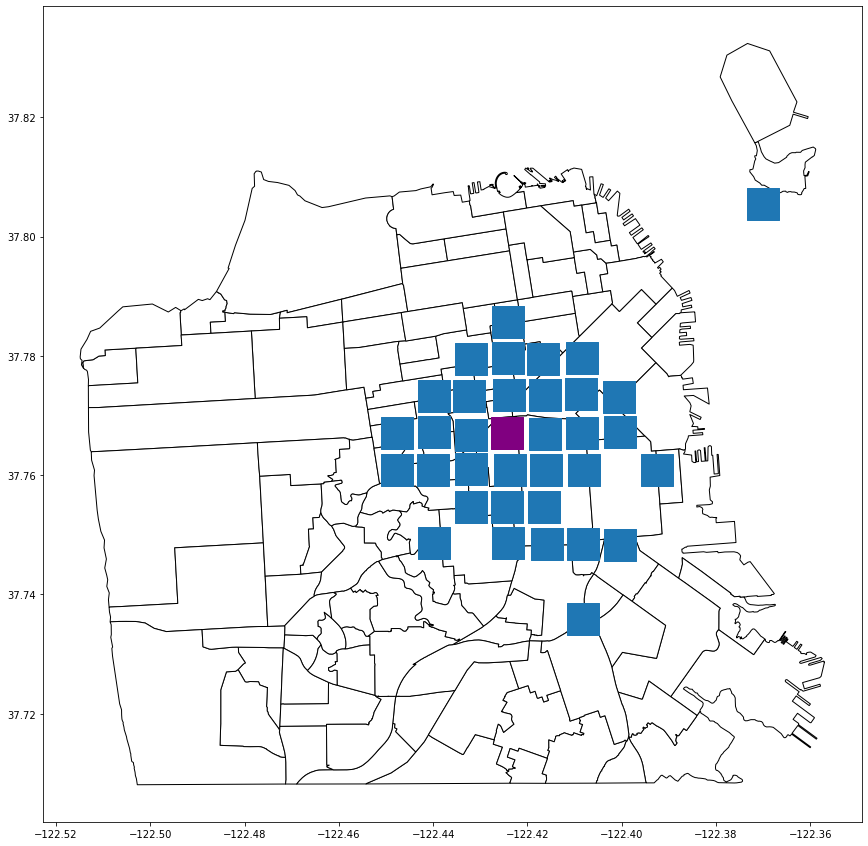

In [207]:
filtered_data = zone_geo_idx.loc[zone_geo_idx.zone_from_idx.eq(230)]
zone_from = filtered_data.loc[:, ['zone_from', 'zone_from_idx']].drop_duplicates()
zone_to = filtered_data.loc[:, ['zone_to', 'zone_to_idx', 'travel_distance_km', 'travel_time_notraffic_seconds']]
zone_to = zone_to.loc[zone_to.travel_time_notraffic_seconds < 1.5 * 60 * 6]

base_map = sf_neighborhoods.geometry.plot(edgecolor="black", color="white")

_ = zone_from.zone_from.plot(c="purple", marker="s", markersize=1000, ax=base_map)
_ = zone_to.zone_to.plot(markersize=1000, marker="s", ax=base_map)

# _ = zone_travel_test.apply(
#     lambda x: base_map.annotate(
#         text=str(x["index"]), 
#         xy=x.zone_to.coords[0], 
#         color='blue', 
#         ha='center', 
#         size="10"), axis=1)


In [208]:
zone_geo_idx.to_csv(data_dir_prefix+"raw/zone_distances_fixed.csv")